# Twitter Data Preprocessing

Importing all libraries. 

In [3]:
# Imports

import glob
import string
import ast
import json
import time

from datetime import date
from dateutil import parser
import datetime as dt

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
from scipy import interp
from scipy import stats
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#metrics
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Importing Dataset
We import the CSV files

In [4]:
train_data = pd.DataFrame()
for f in glob.glob("./cleanedData/Cleaned_TrainData.csv"):
    df = pd.read_csv(f)
    train_data = train_data.append(df,ignore_index=True)

In [5]:
test_data = pd.DataFrame()
for f in glob.glob("./cleanedData/Cleaned_TestData.csv"):
    df = pd.read_csv(f)
    test_data = test_data.append(df,ignore_index=True)

Importing Tweets CSV and merging with the User Information CSV.

In [6]:
tweets_train = pd.DataFrame()
for f in glob.glob("./cleanedData/Train_Tweets.csv"):
    df = pd.read_csv(f)
    tweets_train = tweets_train.append(df,ignore_index=True)
tweets_train.dropna(how="all", inplace=True)     

In [7]:
tweets_test = pd.DataFrame()
for f in glob.glob("./cleanedData/Test_Tweets.csv"):
    df = pd.read_csv(f)
    tweets_test = tweets_test.append(df,ignore_index=True)
tweets_test.dropna(how="all", inplace=True)     

In [8]:
def datetime_to_num(df):
    # convert string to time object
    for index,row in df.iterrows():
        days = [0 for _ in range(7)]
        hours = [0 for _ in range(24)]
        x = row['created_at_tweets'][1:-1]
        x =x.split(',')
        for time_date in x:
            time_date = time_date[1:-1]
            time_date = time_date.strip()
            if time_date:
                tweet_date = parser.parse(time_date)
                days[tweet_date.weekday()] += 1
                hours[tweet_date.hour] += 1
        df.loc[index, 'days_std']  = stats.kstest(days,'uniform')[0]
        df.loc[index, 'hours_std'] = stats.kstest(hours,'uniform')[0]
    return df

In [9]:
tweets_train = tweets_train.drop_duplicates('screen_name', keep='first')
tweets_test = tweets_test.drop_duplicates('screen_name', keep='first')
tweets_train = datetime_to_num(tweets_train)
tweets_test = datetime_to_num(tweets_test)

In [10]:
all_data = pd.merge(train_data, tweets_train, on='screen_name', how='left')
test = pd.merge(test_data, tweets_test, on='screen_name', how='left')
all_data = all_data.drop_duplicates('screen_name', keep='first')
test = test.drop_duplicates('screen_name', keep='first')

In [11]:
all_data.info()
all_data = all_data.sample(frac=1).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2788 entries, 0 to 2796
Data columns (total 28 columns):
id                       2788 non-null object
id_str                   2788 non-null object
screen_name              2788 non-null object
location                 1748 non-null object
description              2387 non-null object
url                      1387 non-null object
followers_count          2788 non-null int64
friends_count            2788 non-null int64
listedcount              2788 non-null int64
created_at               2788 non-null object
favourites_count         2788 non-null int64
verified                 2788 non-null bool
statuses_count           2788 non-null int64
lang                     2788 non-null object
status                   2674 non-null object
default_profile          2788 non-null bool
default_profile_image    2788 non-null bool
has_extended_profile     2782 non-null object
name                     2788 non-null object
bot                      2788 

In [12]:
all_data.head(1)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,...,name,bot,In_reply,retweet_count,fav_count,total_usrmention,created_at_tweets,texts,days_std,hours_std
0,7.58E+17,7.58E+17,monfactory_bot,Duran Duran Universe,"Tweets quotes from Polygon's Monster Factory, ...",https://t.co/AWgLuV8s9J,9723,4,25,7/27/16 23:05,...,Monster Factory Bot,1,0.0,100.0,100.0,0.0,"['Sat May 06 02:21:14 +0000 2017', 'Sat May 06...",['Blade and Soul was opened up by Big Tobacco!...,1.0,0.5


In [13]:
train, validationSet = train_test_split(all_data, test_size = 0.2)

In [14]:
train.shape , validationSet.shape

((2230, 28), (558, 28))

# Visualizing Data

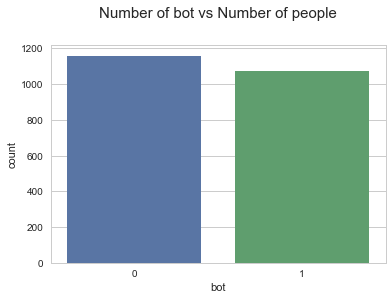

In [13]:
plt.title('Number of bot vs Number of people', y=1.1, size=15)
sns.countplot('bot', data=train)

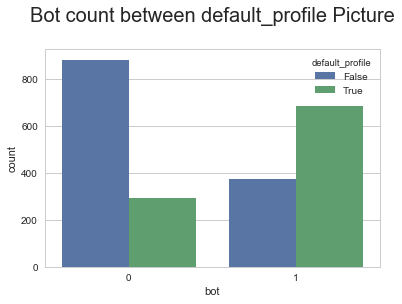

In [15]:
plt.title('Bot count between default_profile Picture', size=20, y=1.1)
sns.countplot(x = 'bot', hue='default_profile', data=train)

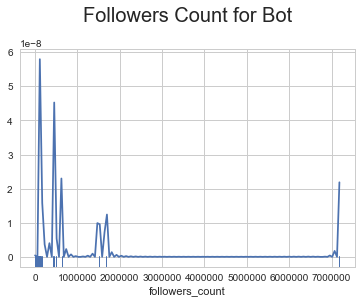

In [16]:
plt.title('Followers Count for Bot', size=20, y=1.1)
df1 = train[['followers_count','bot']]
bot_len  = df1.ix[(df1['bot']==1)]
sns.distplot(bot_len['followers_count'], rug=True, hist=False)

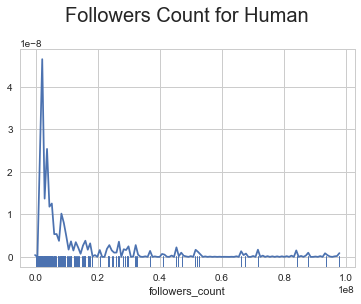

In [17]:
plt.title('Followers Count for Human', size=20, y=1.1)
df1 = train[['followers_count','bot']]
bot_len  = df1.ix[(df1['bot']==0)]
sns.distplot(bot_len['followers_count'], rug=True, hist=False)

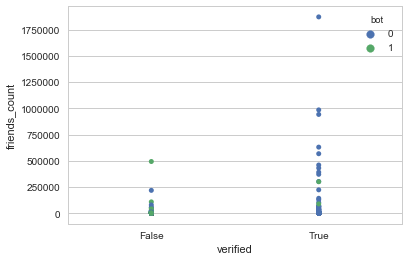

In [18]:
ax = sns.stripplot(x="verified", y="friends_count", hue="bot",data=train)

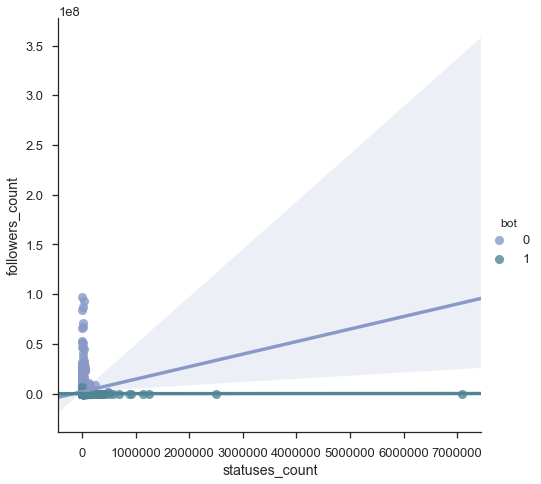

In [19]:
import seaborn as sns
sns.set(style="ticks", context="talk")
pal = sns.cubehelix_palette(4, 1.5, .75, light=.6, dark=.2)
g = sns.lmplot(x="statuses_count", y="followers_count", hue="bot", data=train,
               palette=pal, size=7)
g.set_axis_labels("statuses_count", "followers_count")

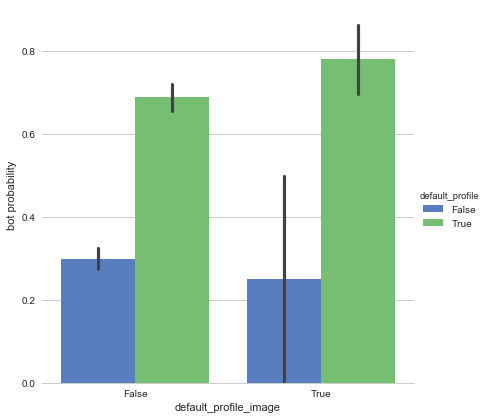

In [20]:
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="default_profile_image", y="bot", hue="default_profile", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("bot probability")

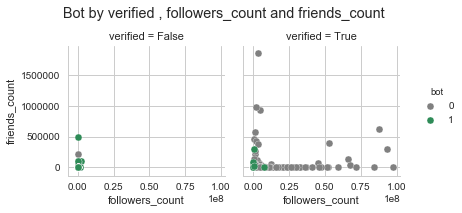

In [21]:
g = sns.FacetGrid(all_data, hue="bot", col="verified", margin_titles=True,
                  palette={1:"seagreen", 0:"gray"})
g=g.map(plt.scatter, "followers_count", "friends_count",edgecolor="w").add_legend();
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Bot by verified , followers_count and friends_count');

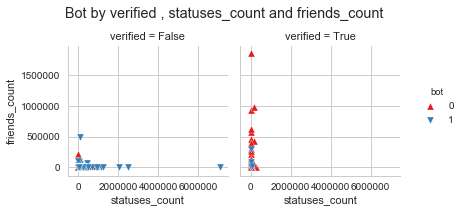

In [22]:
g = sns.FacetGrid(all_data, hue="bot", col="verified", margin_titles=True,
                palette="Set1",hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "statuses_count", "friends_count",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Bot by verified , statuses_count and friends_count');

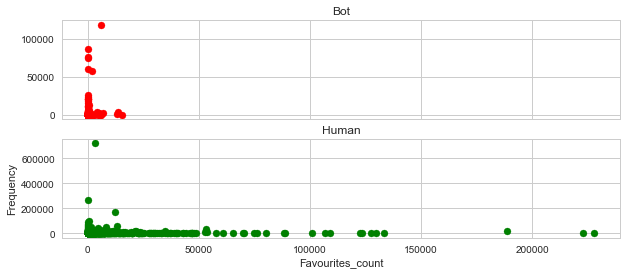

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

bins = 2

ax1.scatter(train.listedcount[train.bot == 1],train.favourites_count[train.bot == 1],c='r')
ax1.set_title('Bot')

ax2.scatter( train.listedcount[train.bot == 0],train.favourites_count[train.bot == 0],c='g')
ax2.set_title('Human')

plt.xlabel('Favourites_count')
plt.ylabel('Frequency')
plt.show()

# Transforming Features

In [15]:
def returnDates(x,valid):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}    
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    if x.startswith("'") and x.endswith("'"): x = x[1:-1]
    if x.startswith("'"): x = x[1:]
    date_split = x.split(' ')
    if len(date_split) == 2:
        _date = date_split[0].split('/')
        _date[2] = '20'+_date[2]
        formated_date = '/'.join(map(str,_date))
        time = date_split[1]
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = '/'.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')    
    
    if valid:
        return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    else:
        return pd.to_datetime(time,format='%H:%M').hour

In [16]:
def lexical_diversity(text):
  if (len(text) == 0):
    diversity = 0
  else: 
    diversity = float(len(set(text))) / len(text)
  return diversity

def return_dict(x):
    if not pd.isnull(x) and x.find('_json=') != -1:
        x = x[x.find('_json=')+6:x.find(', coordinates=')]
        x = ast.literal_eval(x)
        return x
    else:
        return None

def status_created_date(x):
    if not pd.isnull(x):
        x = return_dict(x)
        if x is not None:
            x = returnDates(x['created_at'],True)
            return x
    return pd.to_datetime('05/05/2017', format='%m/%d/%Y', errors='coerce')

    
def get_Noun(x):
    word = str(x).strip()
    count = 0
    tagged_sent = pos_tag(word.split())
    for w in tagged_sent:
        if w[1] == 'NNP':
            count+=1
    return count

def in_reply_stats(x):
    x = return_dict(x)
    if x is not None:
        if x['in_reply_to_screen_name'] is not None:
            return 1
    return 0

def tweet_text_data(x):
    x = return_dict(x)
    if x is not None:
        return x['text']
    return 'a'

def nameR(x):
    wordlen = len(str(x).strip().split())
    letters = len(''.join(str(x).strip().split()))
    return letters/wordlen
    

In [17]:
def status_created_at(df):
    df['status_created_at'] = df.status.apply(status_created_date)
    return df

def in_reply_data(df):
    df['in_reply_data'] = df.status.apply(in_reply_stats)
    return df

def tweet_text(df):
    df['tweet_text'] = df.status.apply(tweet_text_data)
    return df

def ff_ratio(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    df.loc[:,'ff_ratio'] = (df.followers_count/df.friends_count)
    return df

def tweets_per_day(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    df.loc[:,'tweets_per_day'] = df.statuses_count/df.acc_age
    return df

def simplfy_followerscount(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    return df  

def simplfy_friendscount(df):
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    return df    

def simplfy_listedcount(df):
    df.listedcount= df.listedcount.apply(lambda x: int(x)+1)
    return df    

def simplfy_favouritescount(df):
    df.loc[:,'favourites_count']= df.favourites_count.apply(lambda x: int(x)+1)
    return df  

def simplfy_statusescount(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    return df 

def drop_features(df):
    return df.drop(['id_str','location','lang','status','created_at','texts','status_created_at',\
                    'modified_date','created_at_tweets','screen_name','description','url'], axis=1)

def replace_None(df):
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].fillna(df.has_extended_profile.median())
    df.loc[:,'verified'] = df['verified'].apply(lambda x: 1 if x else 0)
    df.loc[:,'default_profile'] = df['default_profile'].apply(lambda x: 1 if x else 0)
    df.loc[:,'default_profile_image'] = df['default_profile_image'].apply(lambda x: 1 if x else 0)
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].apply(lambda x: 1 if x else 0)
    return df

def tweets_data_format(df):
    df.loc[:,'days_std'] = df['days_std'].fillna(0)
    df.loc[:,'hours_std'] = df['hours_std'].fillna(0)    
    df.loc[:,'In_reply'] = df['In_reply'].fillna(0)
    df.loc[:,'retweet_count'] = df['retweet_count'].fillna(0)
    df.loc[:,'fav_count'] = df['fav_count'].fillna(0)
    df.loc[:,'total_usrmention'] = df['total_usrmention'].fillna(0)   
    return df

def set_avg(df):
    list = []
    avg_In_reply = []
    avg_retweet_count = []
    avg_fav_count = []
    avg_total_usrmention = []
    for row in df.itertuples():
            lis = str(df['created_at_tweets']).split(",")
            lent = len(lis)
            avg_In_reply.append(row.In_reply/lent)
            avg_retweet_count.append(row.retweet_count/lent)
            avg_fav_count.append(row.fav_count/lent)
            avg_total_usrmention.append(row.total_usrmention/lent)
    df['avg_In_reply'] = avg_In_reply
    df['avg_retweet_count'] = avg_retweet_count
    df['avg_fav_count'] = avg_fav_count
    df['avg_total_usrmention'] = avg_total_usrmention
    return df    

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def diversity(df):
    df.loc[:,'description'].fillna("")    
    df.loc[:,'sn_length'] = df.screen_name.apply(lambda text: len(str(text)))
    df.loc[:,'desc_length'] = df.description.apply(lambda text: len(str(text)))
    grouped = df['screen_name']
    df['diversity'] = grouped.apply(lexical_diversity)
    df.loc[:,"name_length"] = df.name.apply(lambda x: len(''.join(str(x))))
    df.loc[:,"name_words"] = df.name.apply(lambda x: len(str(x).strip().split()))    
    
    df.loc[:,'null_url'] = df.url.apply(lambda x: 1 if (str(x).find('http'))!=-1 else 0)
    df.loc[:,"screennamebot"] = df.screen_name.apply(lambda x: 1 if ('bot' in str(x).lower()) else 0)
    df.loc[:,"namebot"] = df.name.apply(lambda x: 1 if ('bot' in str(x).lower()) else 0)
    df.loc[:,"descbot"] = df.description.apply(lambda x: 1 if ('bot' in str(x).lower()) else 0)
    df.loc[:,"nameratio"] = df.name.apply(lambda x: nameR(x))
    return df

def account_age(df):
    df['acc_age'] = (df['status_created_at'] - df['modified_date'])
    df['acc_age'] = df.acc_age.apply(lambda  x:int(x.days))
    for index,row in df.iterrows():
        if row['acc_age'] < 0:
            value = abs(int((pd.to_datetime('05/05/2017', format='%m/%d/%Y', errors='coerce') - pd.to_datetime(row['modified_date'])).days))
            df.set_value(index,'acc_age',value)
    df['acc_age'] += 1
    return df;

In [18]:
def transform_features(df):  
    df = status_created_at(df)
    df = format_date(df)
    df = account_age(df)
    df = tweets_data_format(df)
    df = tweets_per_day(df)
    df = in_reply_data(df)    
    df = ff_ratio(df)
    df = simplfy_followerscount(df)
    df = simplfy_friendscount(df)
    df = simplfy_listedcount(df)
    df = simplfy_favouritescount(df)
    df = simplfy_statusescount(df)   
    df = replace_None(df)  
    df = diversity(df)
    df = set_avg(df)    
    df = drop_features(df)
    return df

train = transform_features(train)
validationSet = transform_features(validationSet)
test = transform_features(test)
train.head(3)

,id,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,...,name_words,null_url,screennamebot,namebot,descbot,nameratio,avg_In_reply,avg_retweet_count,avg_fav_count,avg_total_usrmention
2026,3337061638,1636,1859,15,7,0,5448,0,0,0,...,3,1,1,0,1,3,0.0,0.084746,0.152542,0.000000
1435,391766775,8,100,1,1,0,3,1,0,0,...,2,0,0,0,0,4,0.0,0.000000,0.016949,0.000000
1196,4841400949,5,652,1,71,0,106,1,0,0,...,2,0,0,0,0,8,0.0,1.677966,0.000000,2.355932


## Visualizing with new features

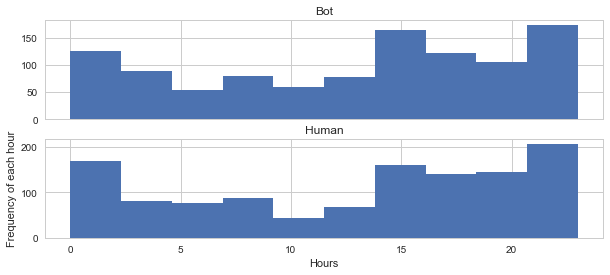

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

bins = 30

ax1.hist(train.modified_hour[train.bot == 1])
ax1.set_title('Bot')

ax2.hist(train.modified_hour[train.bot == 0])
ax2.set_title('Human')

plt.xlabel('Hours')
plt.ylabel('Frequency of each hour')
plt.show()

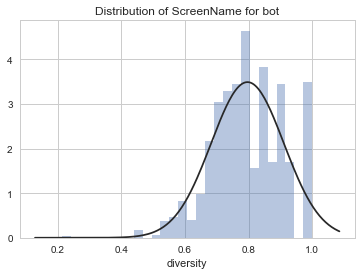

In [26]:
df1 = train[['diversity','bot']]
bot_ = df1.ix[(df1['bot']==1)]
Nonbot_ = df1.ix[(df1['bot']==0)]
from scipy.stats import norm
ax = sns.distplot(bot_['diversity'], fit=norm, kde=False)
plt.title('Distribution of ScreenName for bot')

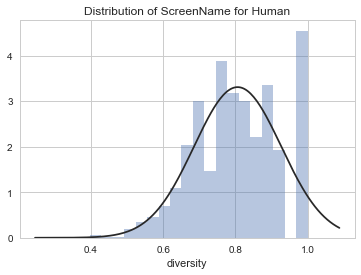

In [27]:
ax = sns.distplot(Nonbot_['diversity'], fit=norm, kde=False)
plt.title('Distribution of ScreenName for Human')

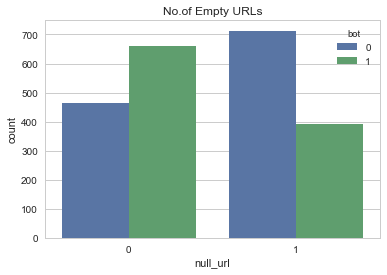

In [28]:
sns.countplot(x ='null_url', hue='bot' ,data=train)
plt.title("No.of Empty URLs")

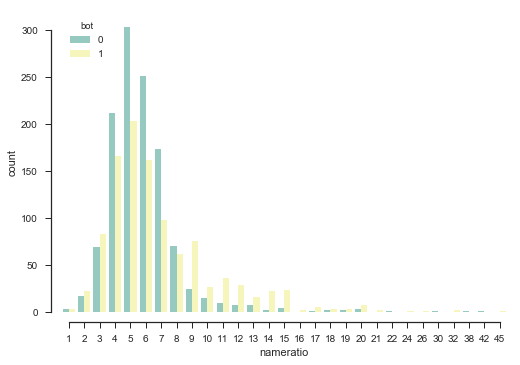

In [29]:
sns.set(style="ticks")
sns.countplot(x="nameratio", hue="bot", data=train, palette="Set3")
sns.despine(offset=10, trim=True)

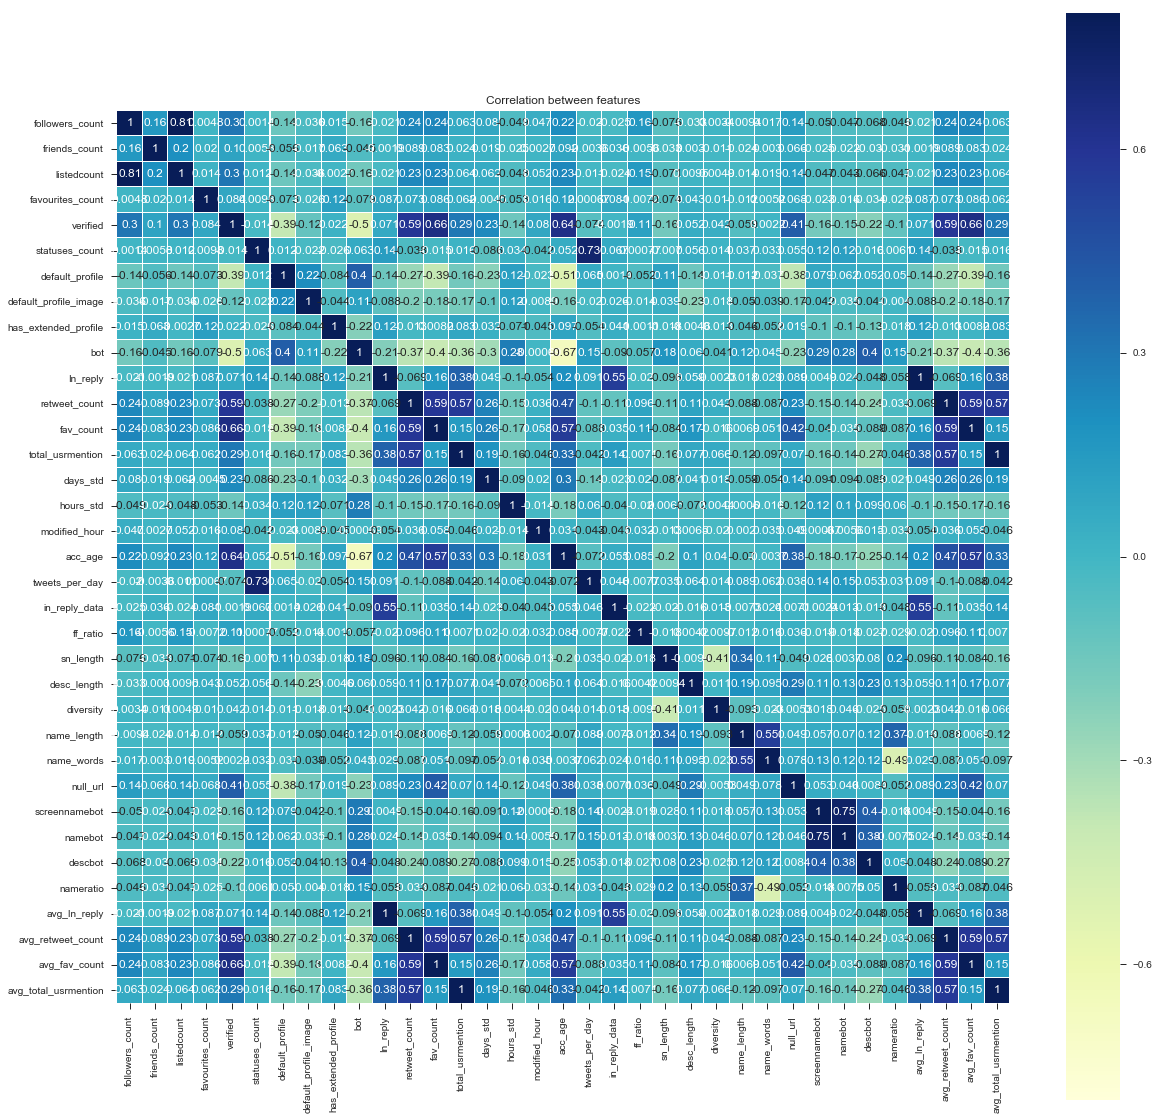

In [65]:
corr=train.corr()#["Survived"]
plt.figure(figsize=(20, 20))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

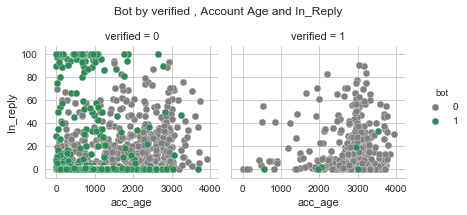

In [19]:
g = sns.FacetGrid(train, hue="bot", col="verified", margin_titles=True,
                  palette={1:"seagreen", 0:"gray"})
g=g.map(plt.scatter, "acc_age", "In_reply",edgecolor="w").add_legend();
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Bot by verified , Account Age and In_Reply');

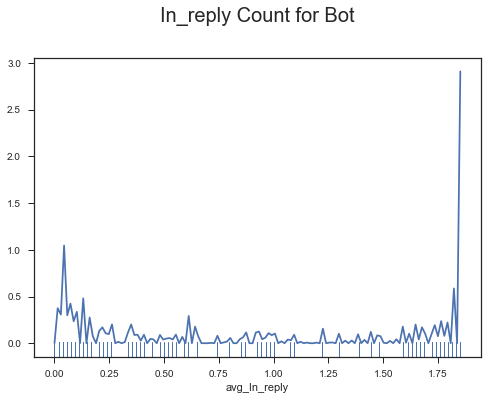

In [50]:
plt.title('In_reply Count for Bot', size=20, y=1.1)
df1 = train[['avg_In_reply','bot']]
bot_len  = df1.ix[(df1['bot']==1)]
sns.distplot(bot_len['avg_In_reply'], rug=True, hist=False)

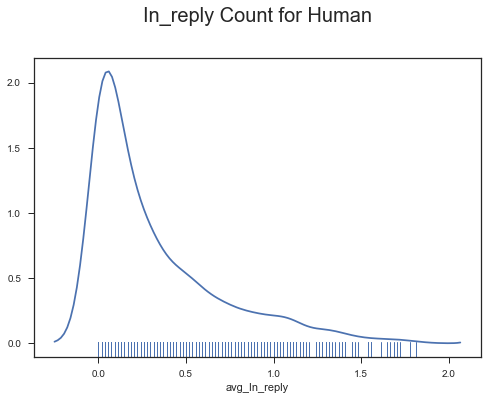

In [51]:
plt.title('In_reply Count for Human', size=20, y=1.1)
df1 = train[['avg_In_reply','bot']]
bot_len  = df1.ix[(df1['bot']==0)]
sns.distplot(bot_len['avg_In_reply'], rug=True, hist=False)

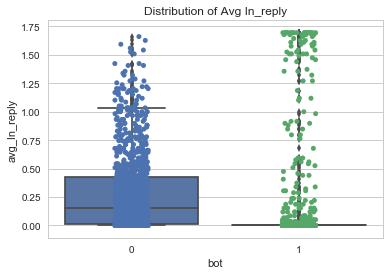

In [20]:
ax = sns.boxplot(x="bot", y="avg_In_reply", 
                data=train)
ax = sns.stripplot(x="bot", y="avg_In_reply",
                   data=train, jitter=True,
                   edgecolor="gray")
sns.plt.title("Distribution of Avg In_reply",fontsize=12); 

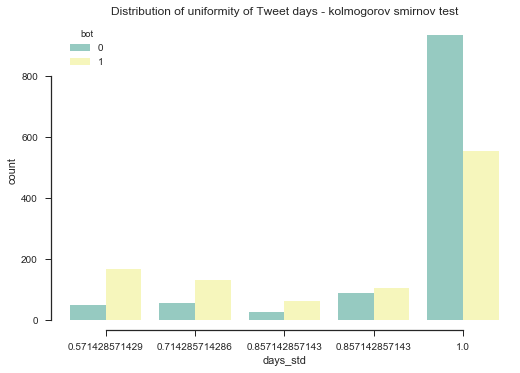

In [37]:
sns.set(style="ticks")
sns.countplot(x="days_std", hue="bot", data=train, palette="Set3")
sns.despine(offset=10, trim=True)
plt.title("Distribution of uniformity of Tweet days - kolmogorov smirnov test")

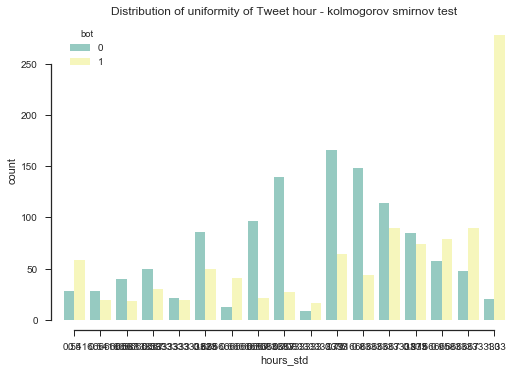

In [58]:
sns.set(style="ticks")
sns.countplot(x="hours_std", hue="bot", data=train, palette="Set3")
sns.despine(offset=10, trim=True)
plt.title("Distribution of uniformity of Tweet hour - kolmogorov smirnov test")

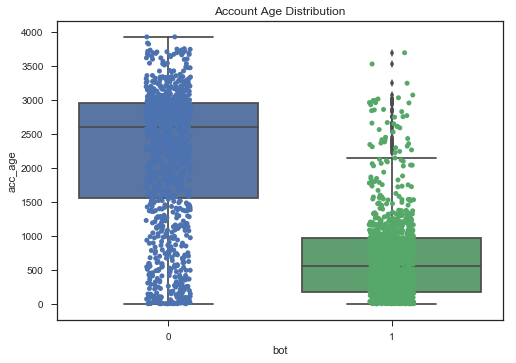

In [102]:
ax = sns.boxplot(x="bot", y="acc_age", 
                data=train)
ax = sns.stripplot(x="bot", y="acc_age",
                   data=train, jitter=True,
                   edgecolor="gray")
sns.plt.title("Account Age Distribution",fontsize=12); 

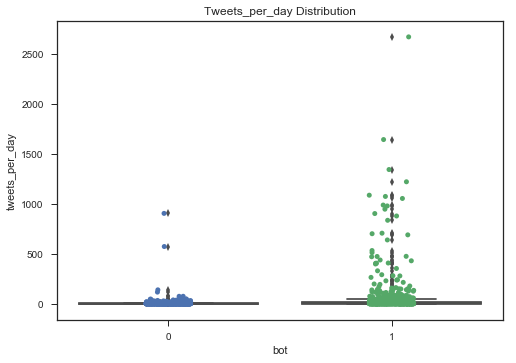

In [59]:
ax = sns.boxplot(x="bot", y="tweets_per_day", 
                data=train)
ax = sns.stripplot(x="bot", y="tweets_per_day",
                   data=train, jitter=True,
                   edgecolor="gray")
sns.plt.title("Tweets_per_day Distribution",fontsize=12); 

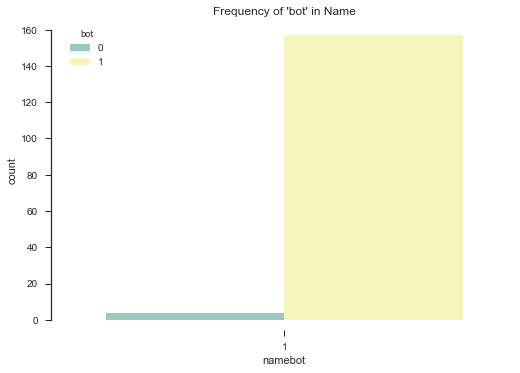

In [86]:
sdata = train[train['namebot'] == 1]
sns.set(style="ticks")
sns.countplot(x="namebot", hue="bot", data=sdata, palette="Set3")
sns.despine(offset=10, trim=True)
plt.title("Frequency of 'bot' in Name" ) 

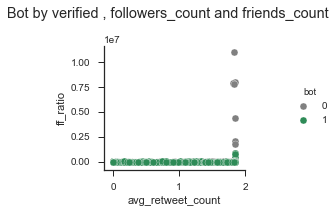

In [90]:
g = sns.FacetGrid(train, hue="bot", margin_titles=True,
                  palette={1:"seagreen", 0:"gray"})
g=g.map(plt.scatter, "avg_retweet_count", "ff_ratio",edgecolor="w").add_legend();
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Bot by verified , followers_count and friends_count');

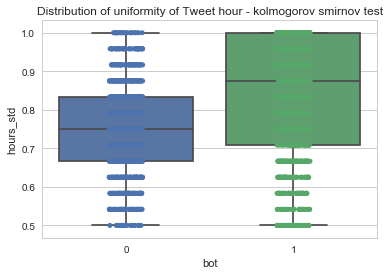

In [20]:
ax = sns.boxplot(x="bot", y="hours_std", 
                data=train)
ax = sns.stripplot(x="bot", y="hours_std",
                   data=train, jitter=True,
                   edgecolor="gray")
sns.plt.title("Distribution of uniformity of Tweet hour - kolmogorov smirnov test",fontsize=12); 

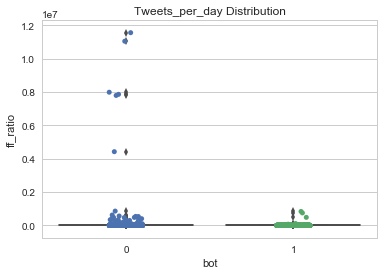

In [21]:
ax = sns.boxplot(x="bot", y="ff_ratio", data=train)
ax = sns.stripplot(x="bot", y="ff_ratio",data=train, jitter=True,edgecolor="gray")
sns.plt.title("Tweets_per_day Distribution",fontsize=12);

### Exporting to CSV

In [17]:
train.shape, validationSet.shape, test.shape

((2230, 37), (558, 37), (575, 37))

In [18]:
train.head(1)

,id,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,...,name_words,null_url,screennamebot,namebot,descbot,nameratio,avg_In_reply,avg_retweet_count,avg_fav_count,avg_total_usrmention
1935,3056108908,70,4,21,1,0,5649,1,0,0,...,3,0,1,1,1,4,0.0,0.0,0.051724,0.0


In [19]:
train.to_csv('./Preprocessed/Train.csv', index = False)
validationSet.to_csv('./Preprocessed/Validation.csv', index = False)
test.to_csv('./Preprocessed/Test.csv', index = False)